# Implementation and optimization of the mean-timer technique in drift tube detectors

## part 0 of LCP project

#### Students: Barone Francesco Pio, Valentini Lorenzo, Nagaro Gianmarco, Ninni Daniele, 

### Target:

Group the hits (rows) by orbits, identify and create events, excluding the external trigger information (for the moment). An event must be a collection of hits expressed in terms of coordinates (chamber, layer, cell) and position within the cell (with the left-right ambiguity NOT resolved).
Verify graphically that the hits in the events align in a pattern similar to the one displayed in the picture above (just few events, for validation purposes).

### Dataset initialization
The dataset is read in the following format:\
HEAD: always 1 (useless)\
FPGA: 0 or 1\
TDC_CHANNEL: in the range 1-128, special values are present too (137, 138, 139)\
ORB_CNT: in the range 0-2^32\
BX: in the range 0-3564\
TDC_MEAS: in the range 1-30\
\
Detector 1 \
FPGA 0, TDC_CHANNEL in [1-64]\
Detector 2\
FPGA 0, TDC_CHANNEL in [65-128]\
Detector 3\
FPGA 1, TDC_CHANNEL in [1-64]\
Detector 4\
FPGA 1, TDC_CHANNEL in [65-128]\

# Event selection

The algorythm for the selction of the events needs to be capable of selecting an appropriate set of events, big enough for not wasting data, and clear enouugh for not having to face too much bad data. It also needs to have good speed. For these reason we chose to restrict our selction of events to a specific set of hit combinations.\
In order to be selected, events need to be such that
1-They are made of 3 up to 4 hits, all belonging to a different layer of tiles.\
2-All the hits of the same event have TDC_CHANNEL index that is at most at three positions of distance from the others.\
3-The time differences between each hit has to be lower than the maximum drift time (390ns).\
4-In the 4 previous and following TDC_CHANNELS there are no hits during the event.\
\
This ensures the fact that we only accept events that are very clear from the noise, that are not mixed with other close events, that have an adequate number of hits to compute their trajectory and that impact the detector with an angle not too far from the perpendicular.\

In [116]:
# general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as ptc
import matplotlib.colors as mc
import math
from scipy import stats

source_file = '/data/Run000262/data_000000.txt'

In [117]:
# loading the dataset
data = pd.read_csv(source_file, sep=",")
print(f'I loaded a dataset of {len(data)} hits')

I loaded a dataset of 1310592 hits


In [118]:
### dataframe elaboration

# detector, layer, tile
data['detector'] = pd.Series( (data["TDC_CHANNEL"]/64).apply(np.ceil) + data["FPGA"]*2 , dtype='int')
data['layer'] = pd.Series( data.TDC_CHANNEL%4, dtype='int')
data['layer'].replace( {0:1, 2:2, 3:3, 1:4}, inplace=True)
data['tile']  = pd.Series( ( ((data.TDC_CHANNEL-1)%64)/4 ).apply(np.floor) , dtype='int')

# time [ns]
t0 = data.ORBIT_CNT.min() # NOTE: because ORBIT_CNT is huge, I shift the time values by the minimum ORBIT_CNT
data['t'] = pd.Series( (data.ORBIT_CNT-t0)*3564*25 + data.BX_COUNTER*25 + data.TDC_MEAS*25/30)

# manage trigger hits
data = data.rename(columns={"HEAD": "trigger"})  # since HEAD is useless, I use it as a trigger marker
data.loc[data.TDC_CHANNEL > 128, ['detector','layer','tile']] = 0  # because these values do not make sense for triggers
data.loc[data.TDC_CHANNEL <= 128, 'trigger'] = 0

# misc
data.head(10)

,trigger,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,detector,layer,tile,t
0,0,1,19,1965859059,2882,5,3,3,4,7.205417e+04
1,0,1,37,1965859067,931,1,3,4,9,7.360758e+05
2,0,0,25,1965859082,1906,19,1,4,6,2.096966e+06
3,0,0,25,1965859082,1916,17,1,4,6,2.097214e+06
4,0,1,82,1965859090,3415,5,4,2,4,2.847479e+06
5,0,0,75,1965859093,1227,17,2,3,2,3.060089e+06
6,0,0,63,1965859094,875,24,1,3,15,3.140395e+06
7,0,0,10,1965859101,1100,2,1,2,2,3.769702e+06
8,0,0,47,1965859117,668,3,1,3,11,5.184502e+06
9,0,1,74,1965859120,2465,10,4,2,2,5.496733e+06


This dataset has 99338.0 triggers.


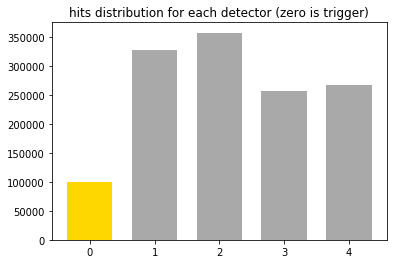

In [119]:
# looking at the distribution of data for each detector
plt.title('hits distribution for each detector (zero is trigger)')
data_distribution,_,patches = plt.hist(data.detector, np.arange(0, 6)-0.5 , rwidth = 0.7, color = 'darkgrey')
patches[0].set_facecolor('gold')
del patches
print(f'This dataset has {data_distribution[0]} triggers.')
plt.show()

## Useful functions

### plotters

In [120]:
def plot_hits(hit_list, title = None, note = None, focus_area = False,
              legend_primer = '"[{:03d}] {:.2f}ns ({:+.2f})".format(hit_id,time,time-prev_time)', 
              legend_x_shift = 0, no_axis = 'default', show_plt = True,
              tile_edgecolor = 'dimgray', tile_linewidth = 0.7, tile_alpha = 1, override_tile_colors = None,
              wire_enable = False, wire_size = 1, wire_alpha = 1, wire_color = 'k' ):
    # This function plots the detector tiles pattern and marks with colors the tiles which register a hit.
    #  input:  hit_list    a list of hits, for instance:  [ (31, 14696.6, 1, 13), (29, 14645.0, 2, 13) ]
    #                           -> each hit is a tuple containing ( HIT_ID, time [ns], layer, tile )
    #     optional:
    #          focus_area     (False)   if True restricts the are of the plot to the zone of detector
    #                                     which is affected by hits
    #          legend_primer  (format)  set the format of the legend
    #                                     -> use 'None' to disable legend
    #                                     -> available variables:   hit_id, time, prev_time, layer, tile, idx
    #          note           (None)    if there is some text, adds it in lower left side of the plot
    #                                     note: do not use it with limited_area = True
    #          ...      the other parameters change the aesthetis of the plot
    #
    #  output:   tiles     a matrix to control the properties of the tiles
    
    fig = plt.figure(figsize=(10, 2), dpi=120)
    ax  = fig.add_subplot(111)
    
    # detector pattern
    dx, dy =  42, 13           # tile shape
    n_layers, n_tiles = 4, 16  # number of layers, and number of tiles per layer
    
    # hit color list
    if override_tile_colors: color_list = [ override_tile_colors ]*len(hit_list)
    else:  color_list = ['tomato','gold','dodgerblue','springgreen', 
                         'orange', 'cyan', 'mediumblue', 'violet', 'hotpink']
    
    wires = []
    tiles = []
    for jj in range(n_layers):
        row = [];
        for ii in range(n_tiles):
            t = ptc.Rectangle( (ii*dx-dx*(jj%2)/2,jj*dy), dx, dy, 
                              edgecolor=tile_edgecolor,facecolor='none',linewidth=tile_linewidth)
            ax.add_patch( t )
            row.append(t)
            wires.append( (ii*dx-dx*(jj%2)/2 + dx/2, jj*dy + dy/2) )
            #ax.text(ii*dx+dx*(jj%2)/2, jj*dy, f'{ii+1}')
        tiles.append(row)
    del row
    
    plt.xlim(-3*dx/2, dx*n_tiles + dx);    plt.ylim(-dy*5, dy*n_layers + 5);
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout();    ax.xaxis.set_visible(False);    ax.yaxis.set_visible(False);
    
    if title: plt.title(title)
    if no_axis == 'default':
        if focus_area: no_axis = True
        else: no_axis = False
    if no_axis: ax.axis('off')
    if focus_area: tiles_range = []
    
    for idx, hit in enumerate(hit_list):
        hit_id, time, layer, tile = hit  # these values are available to legend_primer
        if idx == 0: prev_time = time
        tiles[layer-1][tile].set( facecolor=mc.to_rgba(color_list[idx], alpha=tile_alpha),
                                  label=eval(legend_primer) ) 
        prev_time = time
        if focus_area: tiles_range.append(hit[3])   
        
    if focus_area:  # if true, plots only the appropriate range of tiles
        plt.xlim( -3 + dx*(min(tiles_range)-1), 3 + dx*max(tiles_range) + 3*dx/2)
        plt.ylim( -dy, dy*n_layers + 5)
        if legend_primer != 'None':
            plt.legend( prop={'size': 7}, bbox_to_anchor=(0.98 + legend_x_shift, 0.42) )
        if note: ax.text(3 + dx*(max(tiles_range)-2.5) + 3*dx/2, -dy/2 , note, size=8)
    else:
        if note: ax.text(0, -17, note, size=8)
        if legend_primer != 'None':
            plt.legend( prop={'size': 7}, bbox_to_anchor=(1 + legend_x_shift, 0.42) )
    
    if wire_enable: plt.scatter(*zip(*wires), c=wire_color, s=wire_size, alpha=wire_alpha, zorder=2)
    if show_plt: plt.show()
    return tiles, wires

import colorsys

def scale_lightness( mrgba, scale_l):
    rgba = mc.to_rgba( mrgba );  # converting color from matlab to rgb
    darker_color = [1]*4
    for i in range(0,3):
        darker_color[i] = rgba[i]*scale_l
    darker_color[3] = 1
    return np.array(darker_color)

def plot_positions( hits_list, position_list, unsolved = False, hit_size = 18, 
                    tile_black = 0.15, marker_darken = 0.8,
                    legend_primer = '"[{:03d}] {:.2f}ns ({:+.2f})".format(hit_id,time,time-prev_time)',
                    legend_x_shift = 0, focus_area=False,**kwargs):
    # This function plots the events as x markers given the hits list and the position of the 
    #  marker within each tile.
    #  input:  hit_list    a list of hits, for instance:  [ (31, 14696.6, 1, 13), (29, 14645.0, 2, 13) ]
    #                           -> each hit is a tuple containing ( HIT_ID, time [ns], layer, tile )
    #          position_list     a list of marker positions, for instance:  [-10, 13, -5, 17]
    #                                -> positive values shift the marker on the x positive axis
    #     optional:
    #          unresolved     (False)   if True plots the marker simmetrically to the tile wire
    #          hit_size       (18)      size of the hit marker
    #
    #                 the function inherits parameter list from plot_hits(), for instance:
    #          focus_area     (False)   if True restricts the are of the plot to the zone of detector
    #                                     which is affected by hits
    #          note           (None)    if there is some text, adds it in lower left side of the plot
    #                                     note: do not use it with limited_area = True
    #            ....
    #
    #  output:   tiles     a matrix to control the properties of the tiles
    
    n_layers, n_tiles = 4, 16  # number of layers, and number of tiles per layer
    
    if len(hits_list) != len(position_list):
        print('ERROR: hits & positions should have same elements')
    
    # hit color list
    color_list = ['tomato','gold','dodgerblue','springgreen',
                  'orange','cyan','mediumblue','violet','hotpink']
    
    tls, wrs = plot_hits( hits_list, tile_alpha = tile_black, override_tile_colors='k', 
                          legend_primer='None', show_plt = False, focus_area=focus_area, 
                          wire_enable = True, **kwargs);
    
    for idx, hit in enumerate(hits_list):
        hit_id, time, layer, tile = hit  # these values are available to legend_primer
        if idx == 0: prev_time = time
        wire_coord = wrs[ (layer-1)*n_tiles + tile ]
        mark_coord = ( wire_coord[0] + position_list[idx] , wire_coord[1] )
        plt.scatter((*mark_coord), zorder=2, c=[scale_lightness(color_list[idx], marker_darken)], 
                     marker='x', s=hit_size, label=eval(legend_primer))
        prev_time = time
        if unsolved:
            mark_coord = ( wire_coord[0] - position_list[idx] , wire_coord[1] )
            plt.scatter( (*mark_coord), zorder=2, c=[scale_lightness(color_list[idx], marker_darken)], 
                          marker='x', s=hit_size)
                         
    if legend_primer != 'None':
        if focus_area:
            plt.legend( prop={'size': 7}, bbox_to_anchor=(0.98 + legend_x_shift, 0.42) )
        else:
            plt.legend( prop={'size': 7}, bbox_to_anchor=(1 + legend_x_shift, 0.42) )
    
    plt.show()
    return tls, wrs

The above functions plot using the data structures coming from the search algorithm.

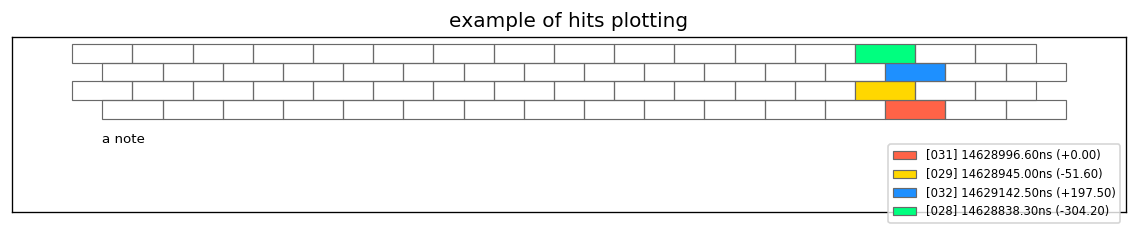

We can also plot only the interested zone of the detector, using focus_area = True:


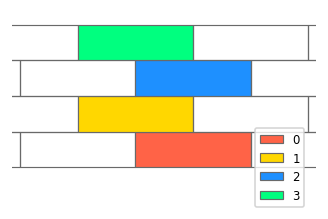

Now we plot an event (output of search algo + meantimer elaboration:


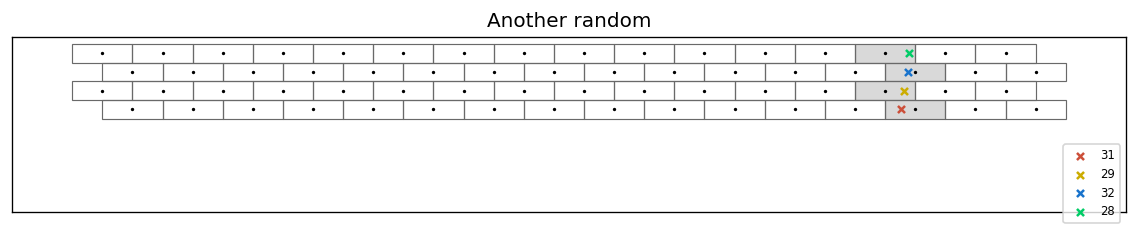

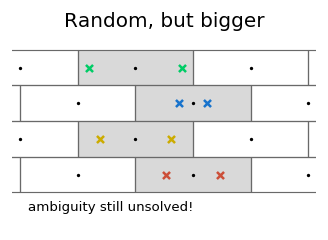

In [121]:
# example of plots using data coming from the selection algorithm:

sample_hits = [ (31, 14628996.6, 1, 13), (29, 14628945.0, 2, 13), 
                (32, 14629142.5, 3, 13), (28, 14628838.3, 4, 13) ]
sample_positions = [-10, 13, -5, 17]

plot_hits( sample_hits ,title = 'example of hits plotting', note = 'a note');

print('We can also plot only the interested zone of the detector, using focus_area = True:')
plot_hits( sample_hits, focus_area = True, legend_primer='idx');

print('Now we plot an event (output of search algo + meantimer elaboration:')
plot_positions( sample_hits, sample_positions, title = 'Another random' , legend_primer='hit_id');
plot_positions( sample_hits, sample_positions, focus_area = True, note = 'ambiguity still unsolved!',
                title = 'Random, but bigger', unsolved=True, legend_primer='None');

These functions instead call the plot functions using the final data structures. The functions automatically select the plot, depending on the data available in input.

In particular, function plot_event_from_dataframe() takes as input a row of the dataframe, or the entire dataframe if a row index is specified as optional argument. 

In [122]:
def plot_event(dic, key = None, time_sorting = True, **kwargs):
    
    if not key:  # automatic selecting the plot based on dictionary keys
        if "positions" in dic:  key = 'positional_plot'
        elif "hits" in dic:    key = 'hits_plot'
        else:
            print('ERROR (plot_event): no key found')
            return 0
    
    if time_sorting:    # performs time sorting of events
        # order by second value of hits tuple (the time)
        sor = sorted( enumerate(dic['hits']), key=lambda tup: tup[1][2]) 
        order = [];  hits = []; 
        for t in sor:
            order.append(t[0]);  hits.append(t[1]);
        dic['hits'] = hits
        if "positions" in dic:
            original = dic['positions'];  sor = [];
            for i in order:
                sor.append( original[i] )
            dic['positions'] = sor

    if key == 'hits_plot':
        return plot_hits( dic["hits"], **kwargs)
    elif key == 'positional_plot':
        if time_sorting:
            dic["positions"] = [ dic["positions"][i] for i in order]
        return plot_positions( dic["hits"], dic["positions"], **kwargs)
    else:
        print('ERROR (plot_event): invalid key')
        return 0



def plot_event_from_dataframe(df, index = None, key=None, debug = False, **kwargs):
    
    if index != None:  # if I provide an index, I have to select index row from dataframe
        df = df.loc[[index]]
        df = df.squeeze(axis=0)  # converting to series
    
    dic =  { }
    
    if 'L1_X' in df:
        positions = []
        for i in range(1,5):  # grab only LX_POSITION
            pos = df[f'L{i}_X']
            if math.isnan( pos ): continue
            positions.append(pos)       
        dic['positions'] = positions
        
    if 'L1_TIME' in df:
        hits = []
        for i in range(1,5):  
            if math.isnan( df[f'L{i}_HIT'] ): continue
            tup = ( int(df[f'L{i}_HIT']) , df[f'L{i}_TIME'], i, int(df[f'L{i}_CELL']) )
            hits.append(tup)
        dic['hits'] = hits
    
    if not bool(dic):
        print('ERROR (plot_event_dataframe): no args found in dataframe, dictionary is empty')
        return 0
    
    if debug: print(dic)
    return plot_event(dic, time_sorting = True, key=key, **kwargs)

Example of plotting using dictionaries:


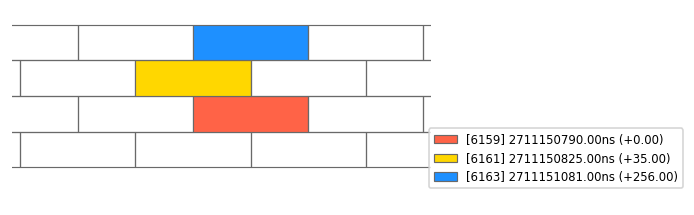

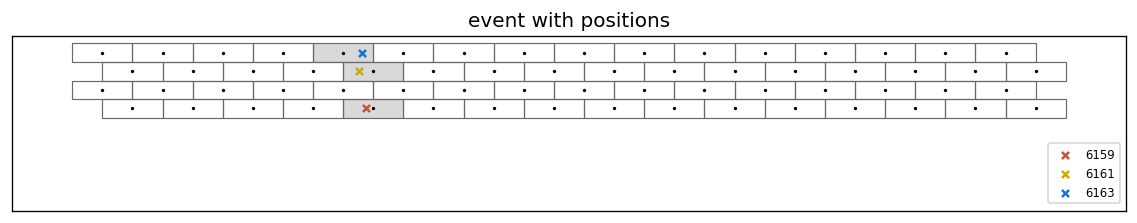

In [123]:
adic = {'hits': [(6163, 2711151081, 4, 12),(6159, 2711150790, 2, 12), (6161, 2711150825, 3, 11)]}
bdic = {'hits': [(6163, 2711151081, 4, 4),(6159, 2711150790, 1, 4), (6161, 2711150825, 3, 4)],
        'positions': [-10, 13, -5, 17]}


print('Example of plotting using dictionaries:')
plot_event(adic, focus_area = True);
plot_event(bdic, title = 'event with positions' , legend_primer='hit_id');

## Event selector algorithm

### Algorithm 3: close hit clustering

In [124]:
def enhanced_close_hit_clustering(dataframe, time_tolerance = 500, keep_rejected = True):
    
    events = [] # list which stores the selected events
    
    # list which store the sensitivity-rejected events
    if keep_rejected: rejected = []

    for i in range(1,62,2):   # for alternative (bigger) mask use range(1,62,4) & (i,i+5)
    
        # margins for the active mask
        lma, rma = i, i+3
        # margins for the sensitivity mask (inclusive)
        lms, rms = max(0, i-4), min(64, i+7)
        
        # slicing by TDC_CHANNEL & selection
        df = data[ ((data['TDC_CHANNEL']-1)%64).between(lms-1,rms-1,inclusive='both') ].sort_values(by=['detector','t'])  # selecting channels 
        df['dt'] = df['t'] - df['t'].shift(1)  # calculating dt
        df.loc[df['dt'] < 0, 'dt'] = 10e6      # solving detector interface issue
        m = df['dt'] < time_tolerance          # mask value with meaningful dt 
        df = df[m.shift(-1)|m]                 # cross-shift the mask to take also the first event of each cluster
        
        # clustering over time and checking event shape
        reject = False
        chain, chain_len = [], 0
        
        rep_checker = np.zeros(4)  # used to discard candidates with hit repetition among layers
        for row in df[['TDC_CHANNEL','t', 'layer','tile','dt']].itertuples(): 
            
            # first element of a new cluster
            if row.dt > time_tolerance:
                
                # store if value is good
                if (((chain_len == 3) or (chain_len == 4)) and (rep_checker.max()==1)):
                    if not reject: events.append( chain )
                    elif keep_rejected: rejected.append( chain )
                
                # resetting the data structure
                reject = False
                chain, chain_len =  [ (row.Index, row.t, row.layer, row.tile) ] , 0
                rep_checker.fill(0);
            
            # another element of cluster
            else:
                chain.append( (row.Index, row.t, row.layer, row.tile) )
            
            # checking if hit is in active mask
            if (lma <= row.TDC_CHANNEL <= rma):  
                rep_checker[row.layer-1] += 1; 
                chain_len = chain_len + 1;
            else:
                reject = True

    
    if keep_rejected: return events, rejected
    else: return events, []

no_triggers = data[ data.trigger == 0 ]
evs, rej = enhanced_close_hit_clustering(no_triggers)

print(f'{len(evs)} events selected + {len(rej)} events rejected')

56941 events selected + 23144 events rejected


In [125]:
print('The algorithm returns the events as lists of hits:')
evs[0:3]

The algorithm returns the events as lists of hits:


[[(45, 19150832.5, 3, 0),
  (47, 19150895.0, 1, 0),
  (49, 19151026.666666668, 2, 0),
  (48, 19151042.5, 4, 0)],
 [(5072, 2207773542.5, 4, 0),
  (5076, 2207773600.0, 1, 0),
  (5074, 2207773622.5, 2, 0),
  (5075, 2207773672.5, 3, 0)],
 [(5975, 2616131095.8333335, 2, 0),
  (5976, 2616131282.5, 4, 0),
  (5977, 2616131417.5, 1, 0)]]

Plotting some examples of accepted events...


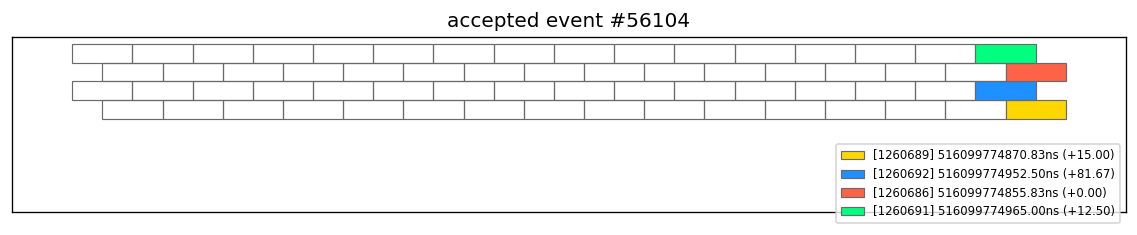

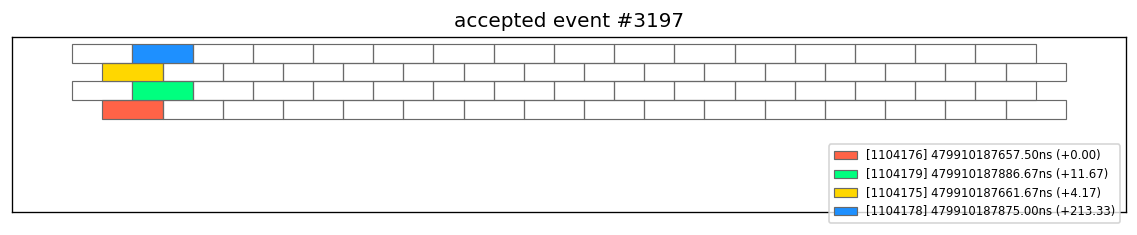

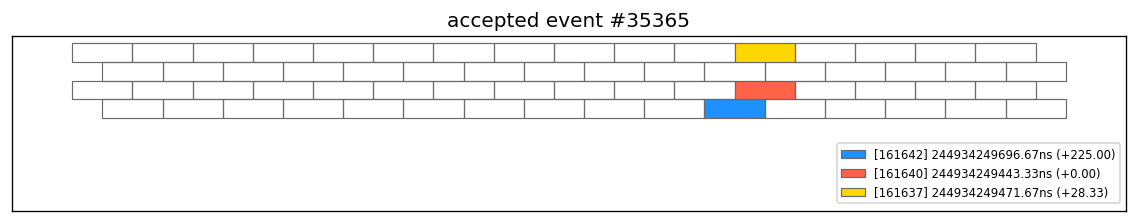

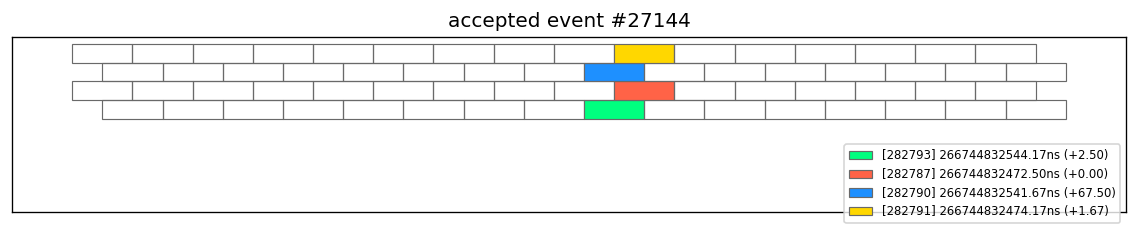

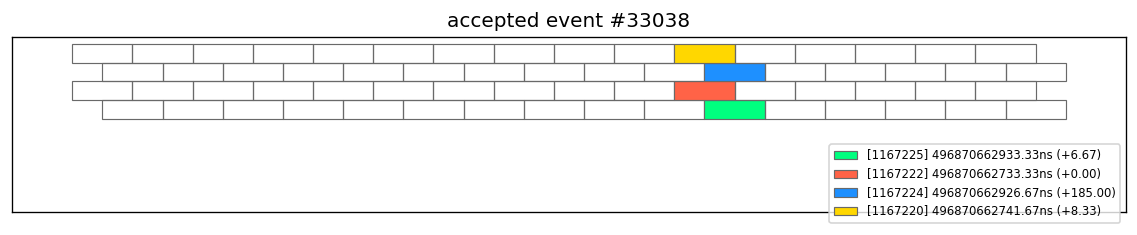

 ... and some examples of rejected events


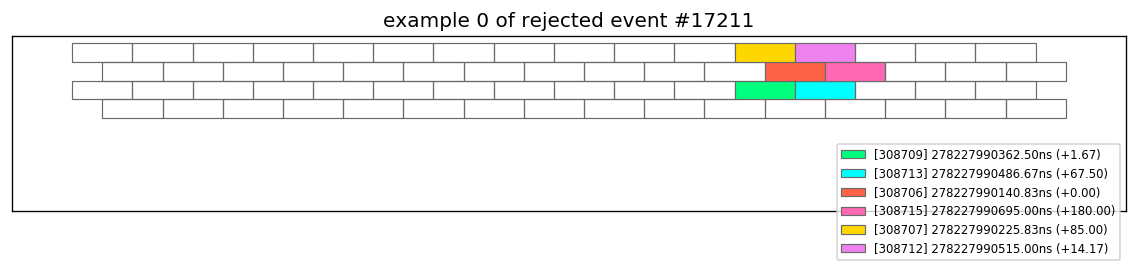

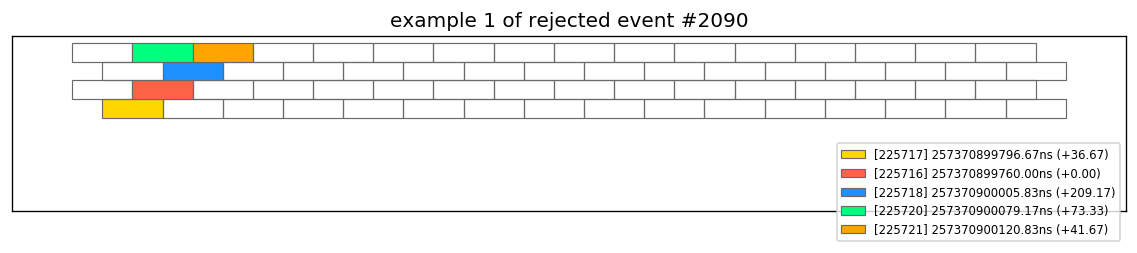

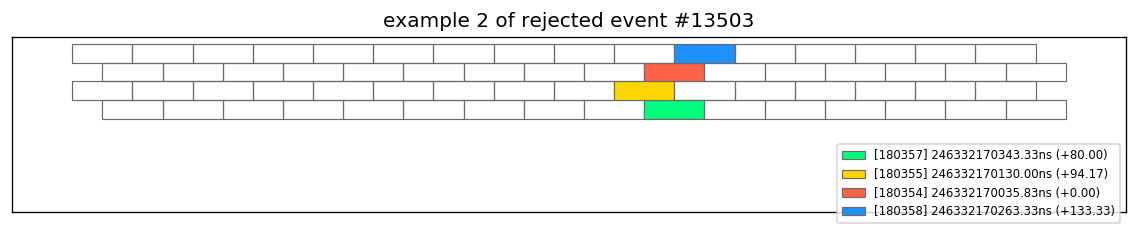

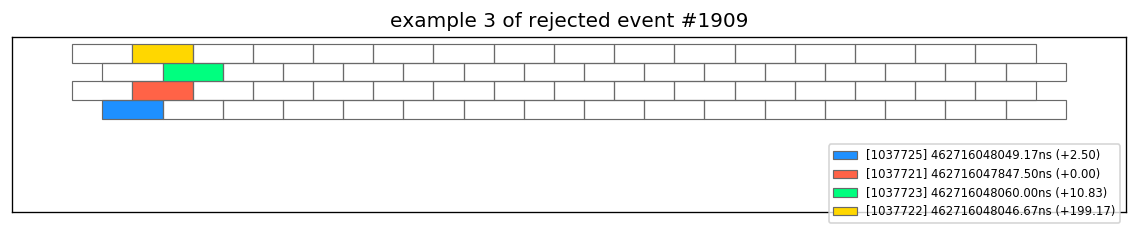

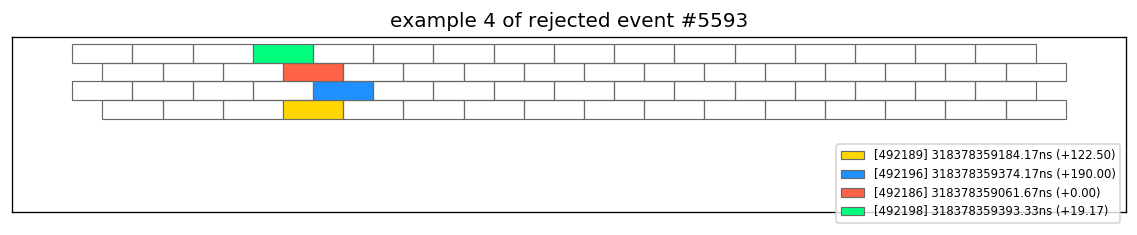

 ... and I like these very much:


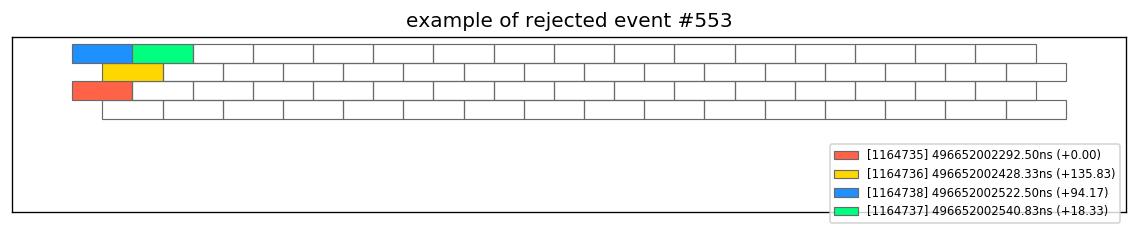

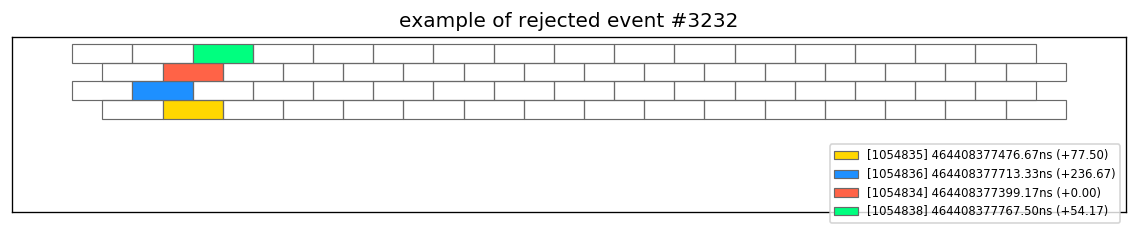

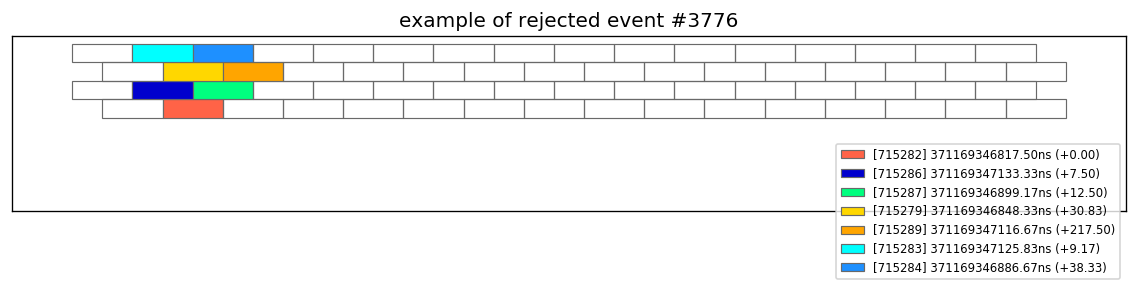

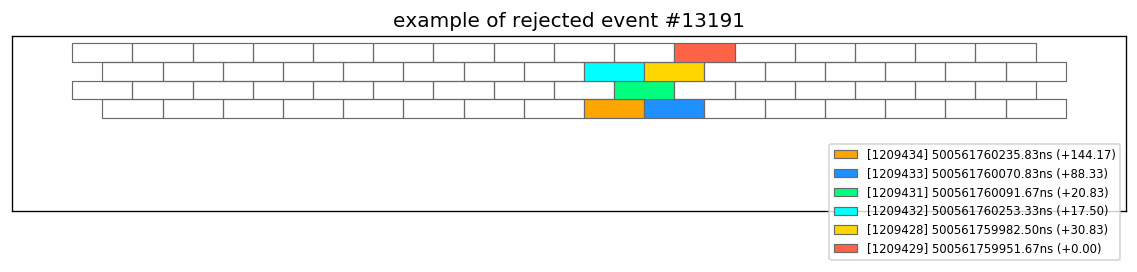

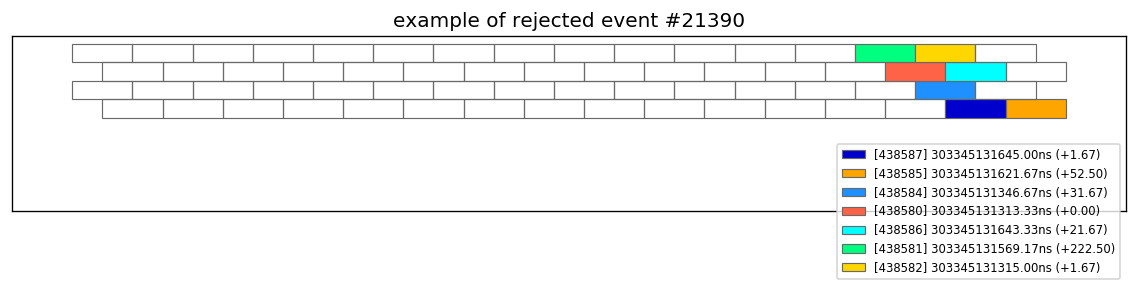

In [126]:
print('Plotting some examples of accepted events...')
for i in range(5):
    y = np.random.randint(0, len(evs))
    plot_hits( evs[y], title = f'accepted event #{y}');

print(' ... and some examples of rejected events')
for i in range(5):
    y = np.random.randint(0, len(rej))
    plot_hits( rej[y], title = f'example {i} of rejected event #{y}');

# interesting rejected events = 553, 3232, 13191, 21390, 3776
print(' ... and I like these very much:')
for i in [553, 3232, 3776, 13191, 21390]:
    plot_hits( rej[i], title = f'example of rejected event #{i}');

## Creating a dataframe of events

In [127]:
def create_events_dataframe(lst):
    # this function takes as input a list of events and creates a dataframe on it
    unwrapped = []
    for event in lst:
        x = [None]*( 3*4 + 1)
        
        layers_id = []
        
        for hit in event:
            hit_id, time, l, tile = hit
            layers_id.append(l)  # to create the layer label
            l = l-1
            x[l*3 ] = int(hit_id)
            x[l*3 + 1] = time
            x[l*3 + 2] = int(tile)
            
        sorted_list = sorted(layers_id)
        x[-1] = str(''.join(str(e) for e in sorted_list))
        unwrapped.append(x)
    return pd.DataFrame( unwrapped,
                         columns=['L1_HIT','L1_TIME','L1_CELL', 'L2_HIT','L2_TIME','L2_CELL',
                                  'L3_HIT','L3_TIME','L3_CELL', 'L4_HIT','L4_TIME','L4_CELL', 'LAYERS'] )

do = create_events_dataframe(evs)
#do['L1_HIT'] = do['L1_HIT'].astype(int)
do

,L1_HIT,L1_TIME,L1_CELL,L2_HIT,L2_TIME,L2_CELL,L3_HIT,L3_TIME,L3_CELL,L4_HIT,L4_TIME,L4_CELL,LAYERS
0,47.0,1.915090e+07,0.0,49.0,1.915103e+07,0.0,45.0,1.915083e+07,0.0,48.0,1.915104e+07,0.0,1234
1,5076.0,2.207774e+09,0.0,5074.0,2.207774e+09,0.0,5075.0,2.207774e+09,0.0,5072.0,2.207774e+09,0.0,1234
2,5977.0,2.616131e+09,0.0,5975.0,2.616131e+09,0.0,NaN,NaN,NaN,5976.0,2.616131e+09,0.0,124
3,NaN,NaN,NaN,8354.0,3.655548e+09,0.0,8356.0,3.655548e+09,0.0,8355.0,3.655548e+09,0.0,234
4,8595.0,3.765115e+09,0.0,8596.0,3.765115e+09,0.0,NaN,NaN,NaN,8597.0,3.765116e+09,0.0,124
5,NaN,NaN,NaN,9788.0,4.305668e+09,0.0,9790.0,4.305668e+09,0.0,9789.0,4.305668e+09,0.0,234
6,NaN,NaN,NaN,12493.0,5.527147e+09,0.0,12495.0,5.527148e+09,0.0,12494.0,5.527147e+09,0.0,234
7,13350.0,5.950649e+09,0.0,13349.0,5.950649e+09,0.0,NaN,NaN,NaN,13351.0,5.950649e+09,0.0,124
8,15271.0,6.832256e+09,0.0,15270.0,6.832255e+09,0.0,NaN,NaN,NaN,15272.0,6.832256e+09,0.0,124
9,18868.0,8.472991e+09,0.0,18867.0,8.472991e+09,0.0,NaN,NaN,NaN,18866.0,8.472991e+09,0.0,124


In [128]:
# optionally save the file
#do.to_csv('/home/lab/dat/262_000_full.txt', index=False)

End of file.